## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomAffine, RandomResizedCrop
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *

In [2]:
torch.manual_seed(809)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                          RandomResizedCrop((size,size),scale=(0.8,1),ratio=(0.9,1.1)),

## Prepare Dataset

In [4]:
size = 64
batch_size = 64
transformation = Compose([RandomHorizontalFlip(), 
                          Resize((size, size)), ToTensor()])

In [5]:
root = 'real_and_fake_face/train'
train_data = create_dataset(root, transformation)
train_loader = produce_loader(train_data, batch_size, shuffle=True)

In [6]:
root = 'real_and_fake_face/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [7]:
root = 'real_and_fake_face/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1757, 3171, 673, 608, 1283, 1048, 2189, 582, 2626]


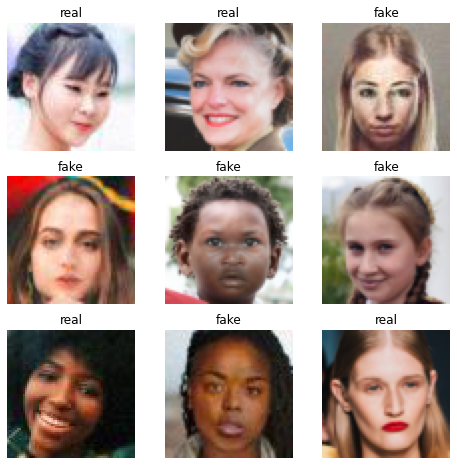

In [8]:
visualize_data(train_data)

[20, 83, 195, 203, 167, 8, 59, 113, 131]


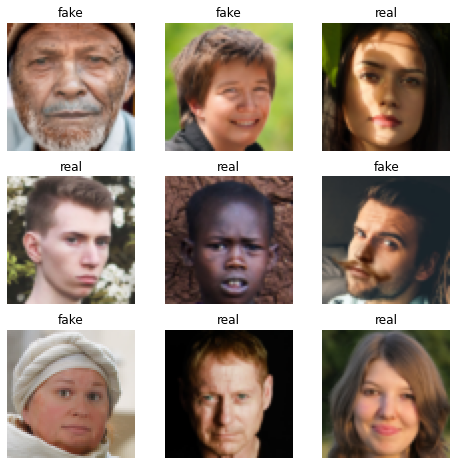

In [9]:
visualize_data(test_data)

## Initialize Model

In [10]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [11]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size = 3

# window size of avgpooling layer
window = 3

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [12]:
model = DeepSearch(hidden=hidden, kernel_size=kernel_size,
                   window=window, hidden_linear=hidden_linear).to(device)
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (3): DeepSearchConv(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5

## Training Model

In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [14]:
optimizer = create_adam_optimizer(model, lr=0.001)

In [15]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.484375
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.515625
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5241477272727273
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.53515625
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5379464285714286
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5324519230769231
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.5352822580645161
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.5286458333333334
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.5339176829268293
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.5315896739130435
Epoch 1/20, Batch number: 50, Cumulated accuracy: 0.5300245098039216
--- Epoch 1/20: Train loss: 0.7609, Train accuracy: 0.5297
--- Epoch 1/20: Val loss: 0.6705, Val accuracy: 0.5441
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.5
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.5390625
Epoch 2/20, Batch number: 10, Cumulated accur

Epoch 10/20, Batch number: 50, Cumulated accuracy: 0.6078431372549019
--- Epoch 10/20: Train loss: 0.6498, Train accuracy: 0.6078
--- Epoch 10/20: Val loss: 0.6675, Val accuracy: 0.6127
Stopped early due to increasing validation loss.


## Testing Model & Performance Curves

In [16]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.7157, Test accuracy: 0.5441


Precision: 0.5925925925925926
Recall: 0.4444444444444444
F1 score: 0.5079365079365079


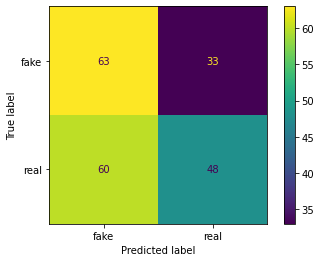

In [17]:
show_metrics(true_labels, model_preds)

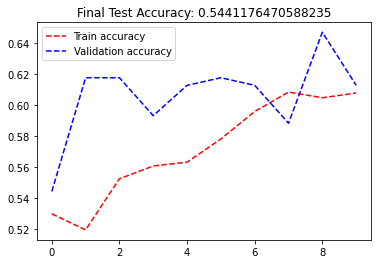

In [18]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

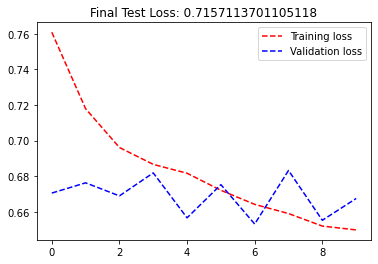

In [19]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [28]:
model.load_state_dict(torch.load("./DeepSearch_checkpoint")["model_state_dict"])

<All keys matched successfully>

Test loss: 0.6965, Test accuracy: 0.5049
Precision: 0.5294117647058824
Recall: 0.5833333333333334
F1 score: 0.5550660792951542


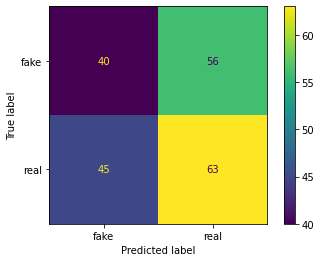

In [29]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)
show_metrics(true_labels, model_preds)

## Viewing Model Predictions

In [20]:
test_loader2 = produce_loader(test_data, 1)

In [21]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.5844155844155844
Recall: 0.4166666666666667
F1 score: 0.4864864864864865


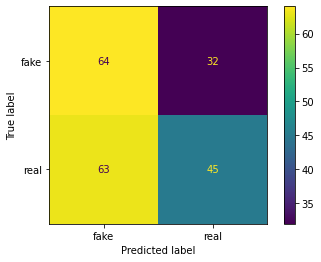

In [22]:
show_metrics(true_labels2, model_preds2)

[64, 40, 51, 60, 70, 108, 90, 102, 104, 100, 75, 63, 48, 72, 57, 108, 95, 0, 12, 94, 53, 107, 87, 60, 4]


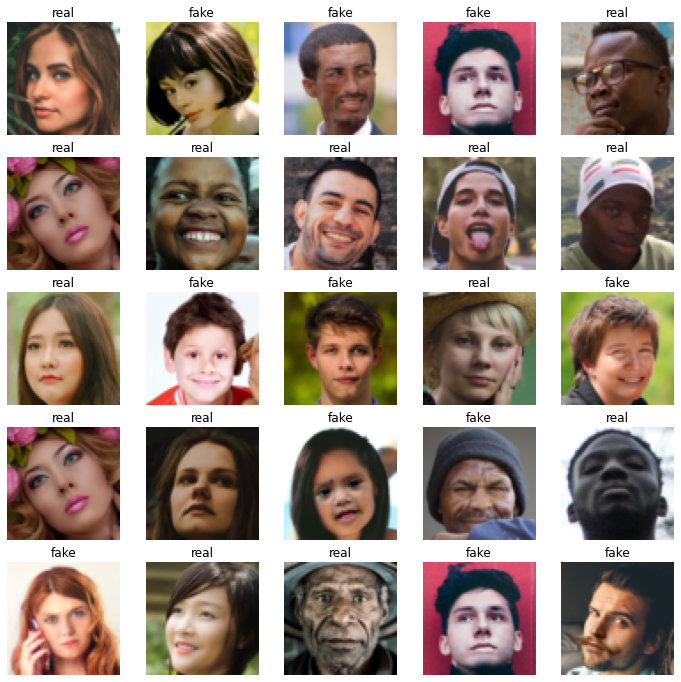

In [25]:
visualize_data(correct_list, (12,12), 5)

[4, 61, 84, 88, 82, 26, 81, 40, 1, 79, 29, 62, 57, 68, 4, 8, 87, 57, 26, 47, 44, 48, 52, 85, 24]


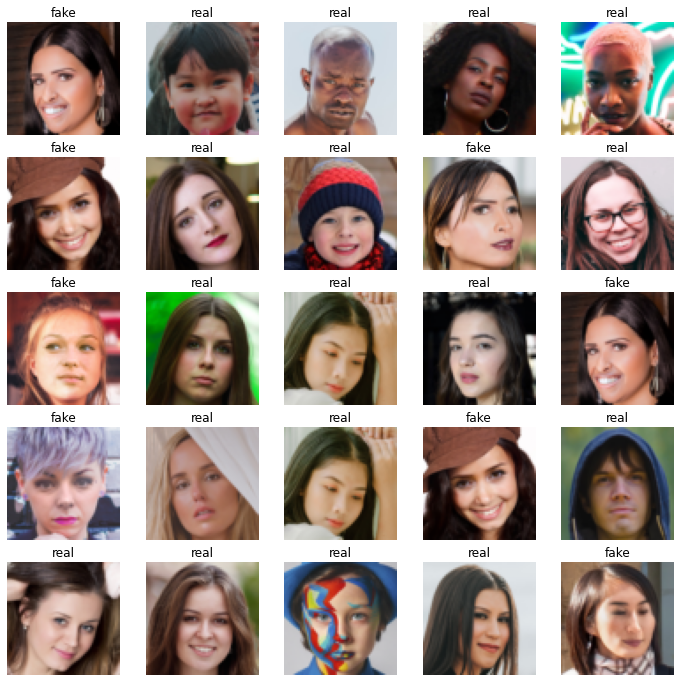

In [26]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepSearch_10epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])